# Three Dimensional SMLM Ananlysis
Defocused, one colour, three dimensional
SMLM is performed on some of the samples,
and evaluated.
From the stack of 50k microscopy images, one
obtains a list of localisations comprised of position (`x,y,z`), photon count (`n`), and a fit parameter (`fit`). Where the `sans serif` typeset
letters refer to the variables in the code listed
in this chapter.



In this section I want to describe our data
analysis pipeline, in order to cut down the massive amount of initial localisations—in our example case over 130k—to distill it to the most
meaningful conclusions.


As a proof of work we used NPCs as sort of
a well defined biological test target. As these
are used frequently for the purpose of validating a new method, it would be nice to quickly
evaluate of how good are the NPCs resolved.
The last Section (NPC Analysis) is thus dedicated to find some metric for best resolved NPCs.

In [ ]:
#@markdown ##import core
#@markdown > Here we import the used packages and the data file we obtain from
#@markdown running the SMLM algorithm.

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import scipy.io
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
 
## settings
#plt.style.use('dark_background')
plt.style.use('default') 

In [ ]:
#@markdown ##import colab
from google.colab import drive
wd = '/gdrive/MyDrive/1 UNI/BIO/'

## google drive
drive.mount('/gdrive', force_remount=True)
data = pd.read_csv( wd +'cell1_tr1000_def500.csv',
                   header = None, names=["x", "y", "z", "n", "bg","fit","id","frame"])
drift = pd.read_csv( wd + 'day2_cell1_driftValues.csv')

Mounted at /gdrive


In [ ]:
#@markdown ##import jupyter
#%matplotlib ipympl
#%matplotlib widget
#%matplotlib interactive
%matplotlib inline
import trackpy
import sdt
from sdt import io, chromatic, multicolor, brightness
 
## local
data = pd.read_csv( 'data/210422_npc/cell2_tr800_def500.csv',
                   header = None, names=["x", "y", "z", "n", "bg","fit","id","frame"])
drift = pd.read_csv('data/210422_npc/cell2_driftValues.csv')

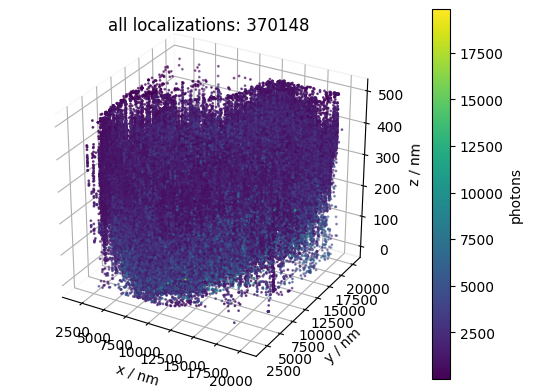

In [ ]:
#@markdown ## plot raw data
#@markdown > import **colab** or **jupyter** first.
 
fig = plt.figure()
ax = fig.add_subplot( projection = '3d' )
f = ax.scatter( data['x'], data['y'], data['z'], s=1 ,c=data['n'] )
ax.set_xlabel('x / nm')
ax.set_ylabel('y / nm')
ax.set_zlabel('z / nm')
plt.title( 'all localizations: ' + str( len( data ) ) )
cbar = plt.colorbar( f, label = 'photons' )
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False

# Drift

The drift of the setup over time can be estimated using `ImageJ`, and is then imported as
drift. In the following block the drift correction is applied to all the 130k localisations,
shown in as 3d plot of all the initial
370k drift corrected localisations.

In [ ]:
#@markdown ## import & scale drift
#@markdown > set **magnification** via factor in drift.
 
drift['Y2']=drift['Y2']*146.6
drift['Y3']=drift['Y3']*146.6
drift['X2']=np.round(drift['X2'])
drift['X3']=np.round(drift['X3'])
 
drift

,X0,Y0,Y1,X2,Y2,X3,Y3
0,2549.5,0.000000,0.000000,1.0,1.280111,1.0,0.702067
1,8463.5,-0.013807,-0.013910,251.0,1.154475,251.0,0.633165
2,16224.0,0.003017,-0.056257,501.0,1.028985,501.0,0.564263
3,26638.5,0.022213,-0.151049,751.0,0.903349,751.0,0.495361
4,41329.0,0.095120,-0.212733,1001.0,0.777860,1001.0,0.426606
...,...,...,...,...,...,...,...
195,NaN,NaN,NaN,48750.0,20.570032,48750.0,-33.802295
196,NaN,NaN,NaN,49000.0,20.793304,49000.0,-33.890402
197,NaN,NaN,NaN,49250.0,21.016429,49250.0,-33.978508
198,NaN,NaN,NaN,49500.0,21.239701,49500.0,-34.066615


In [ ]:
#@markdown ## apply drift correction
 
for i in range(len(drift)-1):
    fr=data[(data['frame']>=drift['X2'].iloc[i]) & (data['frame']<drift['X2'].iloc[i+1])]
    fr['y']=fr['y']-drift['Y2'].iloc[i]
    fr['x']=fr['x']-drift['Y3'].iloc[i]
    data[(data['frame']>=drift['X2'].iloc[i]) & (data['frame']<drift['X2'].iloc[i+1])]=fr

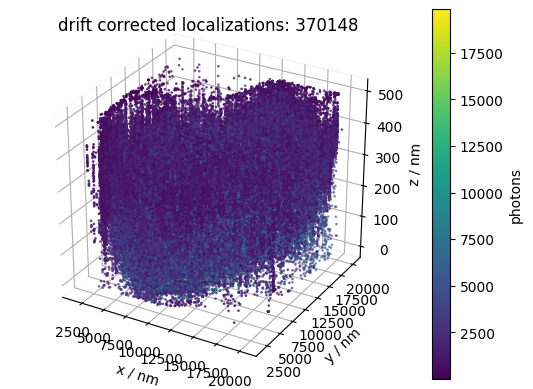

In [ ]:
#@markdown ## plot drift corrected data
 
fig=plt.figure()
ax = fig.add_subplot( projection = '3d' )
f=ax.scatter( data['x'], data['y'], data['z'], s=1 ,c=data['n'] )
ax.set_xlabel('x / nm')
ax.set_ylabel('y / nm')
ax.set_zlabel('z / nm')
plt.title( 'drift corrected localizations: ' + str( len( data ) ) )
cbar=plt.colorbar( f, label = 'photons' )
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False

# Photon Counts

As a preliminary step it might prove useful to look at the photon
count statistics, shown in the Figure below. Here we can
easily see what the supposed intensity of a single molecule is; the
peak, in our case about 2000. Those localisations below may be
considered noise, those far above are probably overlapping or stacked
molecules, so their intensities add up.

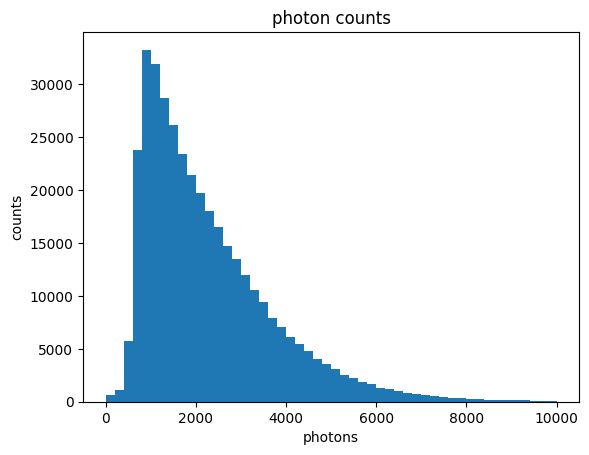

In [ ]:
#@markdown ## Check: photon counts
#@markdown > set `max_photons` accordingly (default: 10000).
max_photons = 10000 #@param {type:"slider", min:0, max:40000, step:1000}
 
fig = plt.figure()
plt.hist( data['n'], bins=50, range=( 0, max_photons ) )
plt.title('photon counts')
plt.xlabel('photons')
plt.ylabel('counts')
plt.tight_layout
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False

#Filter

In this first filter we limit the dataset to the more meaningful
points; like those with intensities between 2k and 7k. Also since we
defocused for 500 nm, only those `z` values between 0 and
499 can be considered realistic. Here 0 means directly attached to the
glass substrate, so negative values would be *inside* the glass
substrate; and thus need to be discarded as unplausible. The dataset
could be filtered by `min_fit`, but to our findings this does not
contribute much.

The Figure below shows a 3d plot of the remaining 154k
localisations after we apply the filter, thus effectively shrinking
down our exemplary data set by about 40\%.

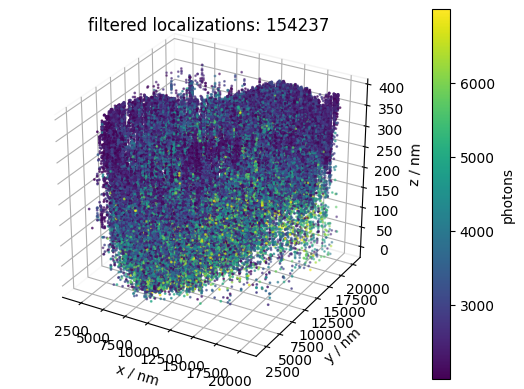

In [ ]:
#@markdown ## filter
#@markdown > set `min_photons` and `max_photons` accordingly (default: 2000 < photons < 7000).\
#@markdown > set `min_z` and `max_z` accordingly (default: 0 < z < 499).\
#@markdown > set `min_fit` accordingly (default: 6e6).
min_photons = 2000 #@param {type:"slider", min:0, max:40000, step:1000}
max_photons = 7000 #@param {type:"slider", min:0, max:40000, step:1000}
min_z = 0 #@param {type:"slider", min:0, max:500, step:1}
max_z = 384 #@param {type:"slider", min:0, max:500, step:1}
min_fit = 7192000 #@param {type:"slider", min:0, max:1e7, step:1000}
 
fdata = data[ ( data['n'] > min_photons ) &
             ( data['n'] < max_photons ) & 
             ( data['z'] > min_z ) &
             ( data['z'] < max_z ) &
             ( data['fit'] < min_fit ) ]
 
fig = plt.figure()
ax = fig.add_subplot( projection = '3d' )
ff = ax.scatter( fdata['x'], fdata['y'], fdata['z'], s=1 ,c=fdata['n'] )
ax.set_xlabel('x / nm')
ax.set_ylabel('y / nm')
ax.set_zlabel('z / nm')
plt.title( 'filtered localizations: ' + str( len( fdata ) ) )
cbar = plt.colorbar( ff, label = 'photons' )
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False

# Tracking

The 50k frames we analyse here are taken with exposure of
20 ms, and 10 ms between consecutive
exposures. Depending on the laser intensity and the buffer composition
the bright state has a specific lifetime $\tau$. This leads to one
exemplary molecule being *on* for some 30 ms (one frame)
while some other is on for 60 ms; and so appears in two
consecutive frames. Since the molecule in those two frames essentially
is the same, we can *track* it over time: effectively averaging the
location if present in multiple frames, thus reducing the amount of
localisations while at the same time increasing their precision.

The parameters `sr` denotes the *search range*, how far apart two
consecutive localisations are still considered *one* particle, this
has to be adjusted based on the physical setup considering vibrations
and the like.

The Figure below shows a 3d plot of the remaining 98k
localisations, after we track the particles. So the tracking step
further shrinks down our exemplary data set by about 60\%.

In [ ]:
#@markdown ## track all in x,y
#@markdown > set `sr` to wanted search range (default: 50).\
#@markdown > set `mem` to wanted memory (default: 10).
sr = 50 #@param {type:"slider", min:0, max:100, step:1}
mem = 10 #@param {type:"slider", min:0, max:100, step:1}
 
linkedxy = trackpy.link_df( fdata, pos_columns = ["x","y","z"], search_range = sr,  memory = mem )
 
particles = linkedxy.groupby( "particle" ).aggregate( np.mean )
std_pos = linkedxy.groupby( "particle" ).aggregate( 'std' )
particles["length"] = linkedxy.groupby( "particle" ).apply( len )
particles["z_std"] = std_pos['z'].copy()
particles["x_std"] = std_pos['x'].copy()
particles["y_std"] = std_pos['y'].copy()
 
particles

NameError: ignored

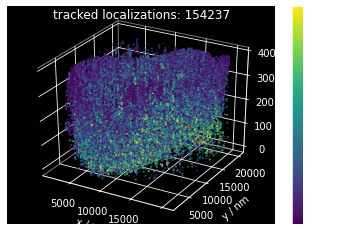

In [ ]:
#@markdown ## cut down to tracked particles
#@markdown > set `localisations = particles` if tracking.\
#@markdown > set `localisations = fdata.iloc[0:10000,0:4]` otherwise to select first 10000 rows.
tracking = False #@param {type:"boolean"}
if tracking:
  localisations = particles
else:
  localisations = fdata.iloc[0:100000000,0:4]
 
fig = plt.figure()
ax = fig.add_subplot( projection = '3d' )
ff = ax.scatter( localisations['x'], localisations['y'], localisations['z'], s=1 ,c=localisations['n'] )
ax.set_xlabel('x / nm')
ax.set_ylabel('y / nm')
ax.set_zlabel('z / nm')
plt.title( 'tracked localizations: ' + str( len( localisations ) ) )
cbar = plt.colorbar( ff, label = 'photons' )
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False

#NPC Analysis
We use NPCs as a test target for our method,
thus we have some additional knowledge, like
the geometry of each individual NPC: they
comprise two stacked tori, each about 150 nm
diameter (in `x,y` direction), and 150 nm apart
(in `z` direction).
Now we can group our dataset with close
to 100 thousand localisations to clusters of
roughly this size in x,y (set `dim=2`). Note that
for the sake of completeness, we include the
possibility of clustering in 3d to spheres in `x,y,z`
(set `dim=3`), but mind that `x,y` and `z` precision
most often greatly varies.
The parameter `min_samples` denotes the
minimum amount of constituents a cluster
must have to be considered such.
So the clustering step further shrinks down our exemplary data set by about 30%.

# Clustering

The Figure below shows the localisations of the 658
identified clusters (omitting 35489 localisations
as noise, due to not belonging to a cluster),
colour coded by photon count.
In our experiments a density based clus-
tering algorithm dbscan [Ester et al., 1996]
worked better than kmeans.

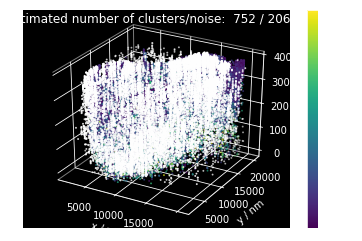

In [ ]:
#@markdown ## compute dbscan
#@markdown > set `dim = 2` for clustering in x and y (default:).\
#@markdown > set `dim = 3` for experimental clustering in 3d; be aware that x,z and y precision probably vary!\
#@markdown > set `eps` (default: 200).\
#@markdown > set `min_samples` (default: 10).
dim = "2" #@param [2, 3]
eps = 100 #@param {type:"slider", min:0, max:500, step:10}
min_samples = 50 #@param {type:"slider", min:1, max:100, step:1}

alocalisations = localisations.to_numpy()
alocalisations[ :, 0:2 ]

db = DBSCAN( eps, min_samples ).fit( alocalisations[ :, 0:int( dim ) ] )
core_samples_mask = np.zeros_like( db.labels_, dtype=bool )
core_samples_mask[ db.core_sample_indices_ ] = True
labels = db.labels_
localisations[ "cluster" ] = labels

# count clusters (ignore noise if present)
n_clusters_ = len( set( labels ) ) - ( 1 if -1 in labels else 0 )
n_noise_ = list( labels ).count( -1 )

#print('Estimated number of clusters: %d' % n_clusters_)
#print('Estimated number of noise points: %d' % n_noise_)

nlocalisations = localisations.loc[ localisations['cluster'] == -1 ]
clocalisations = localisations.loc[ localisations['cluster'] != -1 ]

fig = plt.figure()
ax = fig.add_subplot( projection = '3d' )
ff = ax.scatter( clocalisations['x'], clocalisations['y'], clocalisations['z'], s=1 ,c=clocalisations['n'] )
ff = ax.scatter( nlocalisations['x'], nlocalisations['y'], nlocalisations['z'], s=1 ,c="white" )
ax.set_xlabel('x / nm')
ax.set_ylabel('y / nm')
ax.set_zlabel('z / nm')
plt.title('{0} {1} {2} {3}'.format( 'estimated number of clusters/noise: ', n_clusters_, '/', n_noise_ ) )
cbar = plt.colorbar( ff, label = 'Photons' )
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False

#Filter Clusters

For all the localisations within each of these
identified clusters, we now derive the centroid
position (`xmean,ymean,zmean`), with standard
deviation (`xvar,yvar,zvar`). This enables the
classification of the within-cluster distribution of localisations, alas how well they represent the anticipated NPC geometry.

To obtain this quality, we compose both the
quantity ringness, denoting how well the cluster shapes a ring in `x,y` direction; as well as
the quantity twofold, denoting how well the
cluster resembles two stacked tori in z direction, basically forming a camel-curve in `z` direction. To break this down to one scalar
each, we compute the root mean square (RMS)
of the deviations of each localisations radius
from the cluster centre (in `x,y` direction) from
the known NPC radius. The
quantity twofold is similarly comprised of a
RMS deviation of each localisations z value
from the cluster centre (in `z` direction) from
the known NPC height. The mentioned parameters are thus called `npc_radius`, respective `npc_height`.
The Figure below shows a broad overview of the
location of the cluster centres (not the localisations within), colour coded by photon count.
This should be considered more of a short sanity check than a profound analysis.

In [ ]:
#@markdown ## analyse clusters
#@markdown > set `npc_radius` to NPC radius /nm (default: 50).\
#@markdown > set `npc_radius` to NPC haight /nm (default: 150).
npc_radius = 50 #@param {type:"slider", min:0, max:500, step:1}
npc_height = 25 #@param {type:"slider", min:0, max:500, step:1}

clabels = set(labels)
cnames = [ "counts", "xmean", "ymean", "zmean", "nmean", "xvar", "yvar", "zvar",
          "nvar", "label", "ringness", "twofold" ]
clusters = pd.DataFrame( index = clabels, columns = cnames, dtype="float64" )
clusters[ "label" ] = clabels

for k in clabels:
  tmp = localisations.loc[ localisations['cluster'] == k ]
  clusters.loc[ k, "counts" ] = len( tmp )
  for label in [ "x", "y", "z", "n" ]:
    clusters.loc[ k, label+"mean"  ] = np.mean( tmp.loc[ :, label ] )
    clusters.loc[ k, label+"var"  ] = np.var( tmp.loc[ :, label ] )

  ## xy: radius (distance to centroid)
  rad = np.sqrt( ( tmp.loc[ :, "x" ] - clusters.loc[ k, "xmean" ] )**2 + 
                ( tmp.loc[ :, "y" ] - clusters.loc[ k, "ymean" ] )**2 )
  ## xy: radius rms deviation from NPC radius
  clusters.loc[ k, "ringness"  ] = np.sqrt( sum( ( rad - npc_radius )**2 ) )

  ## z: radius (distance to centroid)
  rad = abs( tmp.loc[ :, "z" ] - clusters.loc[ k, "zmean" ] )
  ## z: radius rms deviation from NPC radius
  clusters.loc[ k, "twofold"  ] = np.sqrt( sum( ( rad - npc_height )**2 ) )

print( * [ 'analysed clusters: ', len( clusters ) ] )

analysed clusters:  753


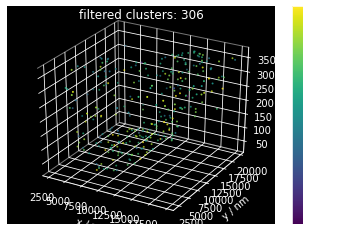

In [ ]:
#@markdown ## filter clusters
#@markdown > set `count_threshold` to min elements (counts) in cluster (default: 30)\
#@markdown > set `diameter_threshold` to max x,y (radius) deviation of cluster from NPC diameter (default: 200)\
#@markdown > set `twofold_threshold` to max z (radius) deviation of cluster from NPC height (default: 200)\
#@markdown > set `xyvar_threshold` to wanted x,y variance (default: 1e4)\
#@markdown > set `zvar_threshold` to wanted z variance (default: 1e4)
count_threshold = 100 #@param {type:"slider", min:0, max:200, step:1}
diameter_threshold = 500 #@param {type:"slider", min:0, max:500, step:10}
twofold_threshold = 1000 #@param {type:"slider", min:0, max:1000, step:10}
xyvar_threshold = 100000 #@param {type:"slider", min:0, max:1e5, step:1e3}
zvar_threshold = 100000 #@param {type:"slider", min:0, max:1e5, step:1e3}

fclusters = clusters[ ( clusters['counts'] < count_threshold ) &
                     ( clusters['ringness'] < diameter_threshold ) &
                     ( clusters['twofold'] < twofold_threshold ) &
                     ( clusters['xvar'] < xyvar_threshold ) & 
                     ( clusters['yvar'] < xyvar_threshold ) &
                     ( clusters['zvar'] < zvar_threshold ) ]

fig = plt.figure()
ax = fig.add_subplot( projection = '3d' )
ff = ax.scatter( fclusters['xmean'], fclusters['ymean'], fclusters['zmean'], s=1 ,c=fclusters['counts'] )
ax.set_xlabel('x / nm')
ax.set_ylabel('y / nm')
ax.set_zlabel('z / nm')
plt.title( 'filtered clusters: ' + str( len( fclusters ) ) )
cbar = plt.colorbar( ff, label='counts' )
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False

#Select Clusters

Now we possess all the information needed to
evaluate the list of clusters; for example to sort
for the lets say 10 *most ringlike* clusters. Or, by
setting `sort = ringness + twofold`, we
may find the 10 *best* clusters in terms of both
`ringness` and `twofold`—weighted equally—
which would comprise the 10 *overall best*, thus
most NPC like clusters.
For sake of completeness we also include the
`x,y` and `z` variances, even if they do not comprise a very meaningful parameter in the particular case due to the NPCs geometry.
The Figures below show a 3d plot
of the localisations within the 10 *best* clusters,
colour coded by photon count respective by
cluster assignment.

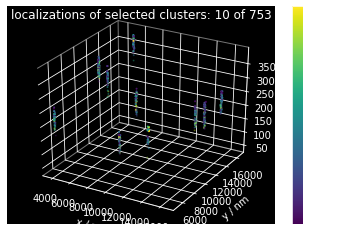

In [ ]:
#@markdown ## select best clusters & plot localisations
#@markdown > set `show_clusters` to wanted number of best clusters (default: 100).\
#@markdown > set `sort` to sort the best clusters (default: ringness + twofold).
show_clusters = 10 #@param {type:"slider", min:0, max:1000, step:1}
sort = 'ringness + twofold' #@param [ "ringness + twofold", "twofold", "ringness", "xyvar" , "xvar" ]

if sort == "xvar": # sort by variance
    sclusters = fclusters.sort_values( "xvar" )
elif sort == "xyvar": # sort by x and y variance using least squares
    sclusters = fclusters.loc[ ( fclusters.xvar ** 2 + fclusters.yvar ** 2 ).sort_values().index ]
elif sort == "ringness": # sort by ringness (deviation to ringness)
    sclusters = fclusters.sort_values( "ringness" )
elif sort == "twofold": # sort by ringness (deviation to ringness)
    sclusters = fclusters.sort_values( "twofold" )
elif sort == "ringness + twofold": # sort by ringness (deviation to ringness)
    sclusters = fclusters.loc[ ( fclusters.twofold ** 2 + fclusters.ringness ** 2 ).sort_values().index ]

show_clusters = min( show_clusters, len( sclusters ) )
selected_clusters = sclusters["label"].iloc[ 0:show_clusters ]

fig = plt.figure()
ax = fig.add_subplot( projection = '3d' )
for clus in selected_clusters:
  flocalisations = localisations[ ( localisations['cluster'] == clus ) ]
  ff = ax.scatter( flocalisations['x'], flocalisations['y'], flocalisations['z'], s=1 ,c = flocalisations['n'] )

ax.set_xlabel('x / nm')
ax.set_ylabel('y / nm')
ax.set_zlabel('z / nm')
plt.title( "localizations of selected clusters: " + 
          str( len( selected_clusters ) ) +
          ' of ' + str( len( clusters ) ))
cbar = plt.colorbar( ff, label = 'photons' )
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


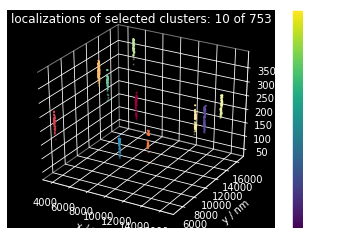

In [ ]:
#@markdown ## plot localisations as colored clusters

sclusters['color'] = ""
vec = np.linspace( 0, 1, len( selected_clusters ) )
for each in range( len( selected_clusters ) ):
  sclusters['color'].iloc[ each ] = plt.cm.Spectral( vec[ each ] )

fig = plt.figure()
ax = fig.add_subplot( projection = '3d' )
for clus in selected_clusters:
  flocalisations = localisations[ ( localisations['cluster'] == clus ) ]
  #print( tuple(  sclusters.loc[clus, "color" ] ) )
  ff = ax.scatter( flocalisations['x'], flocalisations['y'], flocalisations['z'],
                  s=1 ,color = tuple(  sclusters.loc[ clus, "color" ] ) )

ax.set_xlabel('x / nm')
ax.set_ylabel('y / nm')
ax.set_zlabel('z / nm')
plt.title( "localizations of selected clusters: " + 
          str( len( selected_clusters ) ) +
          ' of ' + str( len( clusters ) ))
cbar = plt.colorbar( ff, label = 'cluster' )
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False

#X,Y,Z Histograms

As a further sanity check, we plot the histograms for selected clusters (`plot_cluster`),
in `x,y` and `z` direction; to figure out if the sorting did work effectively—thus the higher sorted
clusters are indeed better examples of NPCs.
The Figure below shows exemplary histograms of
the `x,y` (right) respective `z` distribution (left) of
the localisations within the selected cluster.

Text(0.5, 0.98, 'normalised z distribution of cluster 3')

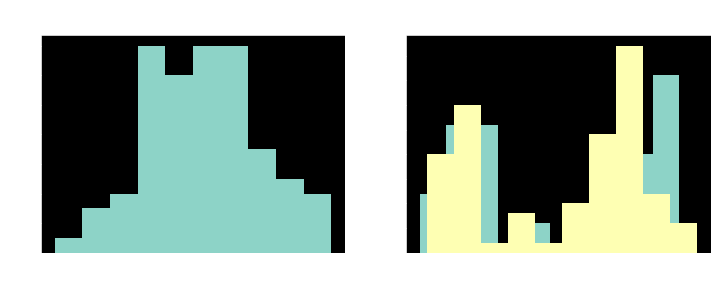

In [ ]:
#@markdown ## Check: z distribution
#@markdown > set `plot_cluster` to wanted cluster (default: 0).
plot_cluster = 3  #@param {type:"slider", min:0, max:100, step:1}
plot_cluster = min( plot_cluster, len( sclusters ) -1 )

tmp = localisations.loc[ localisations['cluster'] == 
                        sclusters.loc[ sclusters.index[ plot_cluster ], "label" ] ]

z = tmp.z - np.mean( tmp.z )

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist( tmp.z - np.mean( tmp.z ) )
axes[0].set_xlabel('z / nm')
axes[0].set_ylabel('counts')
axes[0].set_title( 'z' )

axes[1].hist( tmp.x - np.mean( tmp.x ) )
axes[1].hist( tmp.y - np.mean( tmp.y ) )
axes[1].set_ylabel('counts')
axes[1].set_xlabel('x, y / nm')
axes[1].set_title( 'x, y' )

fig.suptitle( 'normalised z distribution of cluster ' + str( plot_cluster ) )